<a href="https://colab.research.google.com/github/Hilal-Uygun/OCR/blob/main/OCR_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**VERİ HAZIRLAMA**

In [43]:
!pip install tensorflow

In [44]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET

In [45]:
vocab = sorted(set('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789+-/. '))
char_to_int = {char: i for i, char in enumerate(vocab)}
int_to_char = {i: char for char, i in char_to_int.items()}

In [46]:
char_to_int = {
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17,
        'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26, '0': 27, '1': 28, '2': 29, '3': 30, '4': 31, '5': 32, '6': 33,
        '7': 34, '8': 35, '9': 36, '+': 37, '-': 38, '/': 39, '.': 40, ' ': 41
    }

In [47]:
def pad_label(encoded_label, max_length):
    padding_needed = max_length - tf.shape(encoded_label)[0]
    padding_tensor = tf.zeros([padding_needed], dtype=tf.int32)
    return tf.concat([encoded_label, padding_tensor], axis=0)

In [48]:
def encode_label(label):
    max_length = 20
    encoded = [char_to_int.get(c, 0) for c in label]
    padded_encoded = np.pad(encoded, (0, max_length - len(encoded)), constant_values=0)
    return tf.convert_to_tensor(padded_encoded, dtype=tf.int32)

In [49]:
def xml_folder(image_folder_path, xml_folder_path):
  images = []
  bounding_boxes = []
  labels = []

  for file in os.listdir(xml_folder_path):
    xml_path = os.path.join(xml_folder_path, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Görüntü dosya adını alma
    filename_elem = root.find('filename')
    if filename_elem is not None:
        image_filename = filename_elem.text
        image_path = os.path.join(image_folder_path, image_filename)
    else:
        print(f"filename bulunamadı: {xml_path}")
        continue

    for obj in root.findall('object'):
      label_elem = obj.find('name')
      if label_elem is not None:
          label = label_elem.text
      else:
          print(f"label bulunamadı: {xml_path}")
          continue

      box = obj.find('bndbox')
      if box is not None:
        x_min_elem = box.find('xmin')
        y_min_elem = box.find('ymin')
        x_max_elem = box.find('xmax')
        y_max_elem = box.find('ymax')

        if (x_min_elem is not None and y_min_elem is not None and
            x_max_elem is not None and y_max_elem is not None):
          x_min = int(x_min_elem.text)
          y_min = int(y_min_elem.text)
          x_max = int(x_max_elem.text)
          y_max = int(y_max_elem.text)


          images.append(image_path)
          bounding_boxes.append((x_min, y_min, x_max, y_max))
          labels.append(label)
        else:
          print(f"Bounding box koordinatları eksik: {xml_path}")
      else:
        print(f"bndbox bulunamadı: {xml_path}")

  return images, bounding_boxes, labels

In [50]:
def preprocess_img(image_path, bounding_box):
  target_size=(400, 600)
  img = cv2.imread(image_path.decode('utf-8'))
  x_min, y_min, x_max, y_max = bounding_box
  cropped_img = img[y_min:y_max, x_min:x_max]

  h, w = cropped_img.shape[:2]
  aspect_ratio = w / h
  target_w, target_h = target_size[1], target_size[0]
  target_aspect_ratio = target_w / target_h

  if aspect_ratio > target_aspect_ratio:
        new_w = target_w
        new_h = int(new_w / aspect_ratio)
  else:
      new_h = target_h
      new_w = int(new_h * aspect_ratio)

  resized_image = cv2.resize(cropped_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

  delta_w = target_w - new_w
  delta_h = target_h - new_h
  top, bottom = delta_h // 2, delta_h - (delta_h // 2)
  left, right = delta_w // 2, delta_w - (delta_w // 2)

  padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
  final_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_AREA)
  gray_img = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
  return np.expand_dims(gray_img, axis=-1).astype(np.float32)

In [51]:
from codecs import encode
def load_data(image_paths, bounding_boxes, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, bounding_boxes, labels))

  def load_prep(image_path, bounding_box, label):
    img = preprocess_img(image_path, bounding_box)
    img = tf.image.convert_image_dtype(img, tf.float32)

    padded_encoded = tf.pad(label, [[0, 20 - tf.size(label)]], constant_values=0)
    return img, padded_encoded

  def map_func(image_path, bounding_box, label):

        img, encoded_label = tf.numpy_function(
         func=load_prep,
         inp=[image_path, bounding_box, label],
         Tout=[tf.float32, tf.int32]
     )
        img.set_shape((600, 400, 1))
        encoded_label = tf.convert_to_tensor(encoded_label, dtype=tf.int32)
        encoded_label.set_shape([20])

        return img, encoded_label

  dataset = dataset.map(map_func)


  return dataset

In [52]:
xml_folder_path = '/content/drive/MyDrive/archive(tire)/annotations'
image_folder_path = '/content/drive/MyDrive/archive(tire)/images'
images, bounding_boxes, labels = xml_folder(image_folder_path, xml_folder_path)
dataset = load_data(image_paths=images, bounding_boxes=bounding_boxes, labels=labels)
encoded_labels = [encode_label(label) for label in labels]

In [53]:
print("Bounding Boxes:", bounding_boxes[:11])
print("Labels:", encoded_labels[:11])

Bounding Boxes: [(259, 180, 492, 758), (572, 116, 864, 1530), (356, 295, 1132, 459), (155, 157, 734, 245), (27, 32, 156, 197), (238, 412, 372, 779), (179, 24, 233, 283), (19, 125, 395, 592), (139, 113, 535, 315), (228, 131, 327, 656), (331, 399, 426, 710)]
Labels: [<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([13, 33, 35,  1, 41, 10,  3, 28, 18, 41, 28, 28, 29, 28,  0,  0,  0,
        0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(20,), dtype=int32, numpy=
array([13, 37, 19, 41, 29, 30, 32, 39, 32, 32, 18, 29, 27, 41, 28, 27, 29,
       22,  0,  0], dtype=int32)>, <tf.Tensor: shape=(20,), dtype=int32, numpy=
array([ 6,  4,  6, 32, 41, 16,  5, 11, 31, 32, 28, 32,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(20,), dtype=int32, numpy=
array([28, 35, 32, 39, 32, 32, 41, 18, 41, 28, 32,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)>, <tf.Tensor: shape=(20,), dtype=int32, numpy=
array([29, 28, 32, 39, 32, 32, 41, 18, 28, 34,  0,  0,  0,  0,  0,  0

In [54]:
print("Type of labels:", type(labels))
print("First label entry:", labels[0])
print("Type of first label entry:", type(labels[0]))
print("First label entry content:", labels[0])


Type of labels: <class 'list'>
First label entry: M68A JC1R 1121
Type of first label entry: <class 'str'>
First label entry content: M68A JC1R 1121


In [55]:
deneme_label = "M+S R78B PEK44"  # Test etmek için örnek bir etiket
encoded_deneme_label = encode_label(deneme_label)
padded_deneme_label = pad_label(encoded_deneme_label, max_length=20)
print("Encoded Label:", encoded_deneme_label)
print("Padded Label:", padded_deneme_label)


Encoded Label: tf.Tensor([13 37 19 41 18 34 35  2 41 16  5 11 31 31  0  0  0  0  0  0], shape=(20,), dtype=int32)
Padded Label: tf.Tensor([13 37 19 41 18 34 35  2 41 16  5 11 31 31  0  0  0  0  0  0], shape=(20,), dtype=int32)


**MODEL OLUŞTURMA**

In [56]:
#train validation split
train_size = int(0.7*len(images)) #9
train_images = images[:train_size] #0, 1,...,8
train_bounding_boxes = bounding_boxes[:train_size]
train_labels = encoded_labels[:train_size]
val_size = int(0.2*len(images)) + train_size  #2   #11
val_images = images[train_size:val_size] #9, 10
val_bounding_boxes = bounding_boxes[train_size:val_size]
val_labels = encoded_labels[train_size:val_size]
test_images = images[val_size:] #2  #11, 12, 13
test_bounding_boxes = bounding_boxes[val_size:]
test_labels = encoded_labels[val_size:]

train_dataset = load_data(train_images, train_bounding_boxes, train_labels).batch(1, drop_remainder=True)
val_dataset = load_data(val_images, val_bounding_boxes, val_labels).batch(1, drop_remainder=True)
test_dataset = load_data(test_images, test_bounding_boxes, test_labels).batch(1, drop_remainder=True)

In [57]:
# Eğitim verisinin bir örneğini kontrol etme
for image, label in train_dataset.take(1):
    print("Image Shape:", image.shape)
    print("Label Shape:", label.shape)
    print("Label Content:", label.numpy())

print("Train Labels Shape:", np.array(train_labels).shape)
print("Validation Labels Shape:", np.array(val_labels).shape)

print("First Label Length:", len(train_labels[0]))
print("First Label Content:", train_labels[0])


Image Shape: (1, 600, 400, 1)
Label Shape: (1, 20)
Label Content: [[13 33 35  1 41 10  3 28 18 41 28 28 29 28  0  0  0  0  0  0]]
Train Labels Shape: (9, 20)
Validation Labels Shape: (2, 20)
First Label Length: 20
First Label Content: tf.Tensor([13 33 35  1 41 10  3 28 18 41 28 28 29 28  0  0  0  0  0  0], shape=(20,), dtype=int32)


In [58]:
for image, label in test_dataset.take(1):
    print("Image Shape:", image.shape)
    print("Label Shape:", label.shape)
    print("Label Content:", label.numpy())

print("Test Labels Shape:", np.array(test_labels).shape)

print("First Label Length:", len(test_labels[0]))
print("First Label Content:", test_labels[0])
print("Second Label Length:", len(test_labels[1]))
print("Second Label Content:", test_labels[1])
print("Third Label Length:", len(test_labels[2]))
print("Third Label Content:", test_labels[2])

Image Shape: (1, 600, 400, 1)
Label Shape: (1, 20)
Label Content: [[ 4 15 20 41  8  3 14 31 41 27 28  6 24 41 28 31 28 34  0  0]]
Test Labels Shape: (3, 20)
First Label Length: 20
First Label Content: tf.Tensor([ 4 15 20 41  8  3 14 31 41 27 28  6 24 41 28 31 28 34  0  0], shape=(20,), dtype=int32)
Second Label Length: 20
Second Label Content: tf.Tensor([20 27 27  2 41 27 35 28 33  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int32)
Third Label Length: 20
Third Label Content: tf.Tensor([29 28 32 39 32 32 18 28 34 41 36 31 22 41 13 37 19  0  0  0], shape=(20,), dtype=int32)


Etiket Şekli: (1, 20), Etiket İçeriği: [[ 4 15 20 41  8  3 14 31 41 27 28  6 24 41 28 31 28 34  0  0]]


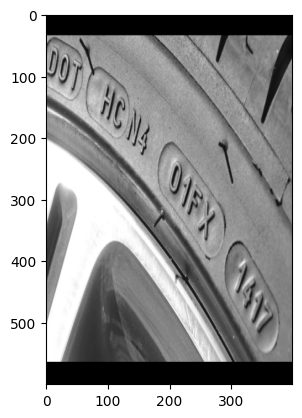

Etiket Şekli: (1, 20), Etiket İçeriği: [[20 27 27  2 41 27 35 28 33  0  0  0  0  0  0  0  0  0  0  0]]


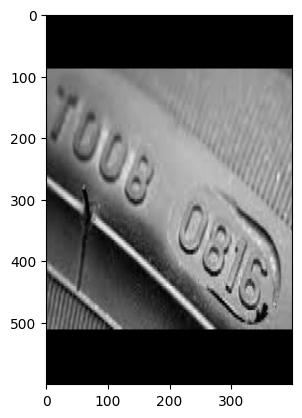

Etiket Şekli: (1, 20), Etiket İçeriği: [[29 28 32 39 32 32 18 28 34 41 36 31 22 41 13 37 19  0  0  0]]


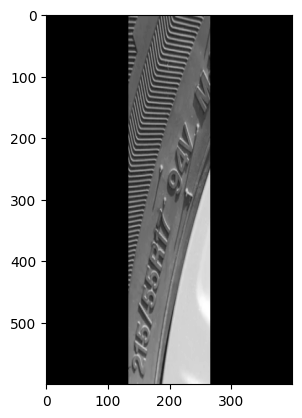

In [60]:
for image, lbl in test_dataset.take(3):
  testimg = image.numpy().reshape((image.shape[1], image.shape[2]))
  lbl = lbl.numpy()
  print(f"Etiket Şekli: {lbl.shape}, Etiket İçeriği: {lbl}")

  lbl = lbl.squeeze()
  if lbl.ndim > 1:
      lbl = lbl.flatten()
  plt.imshow(testimg, cmap='gray')
  plt.show()

Eğitim Verisi Örnekleri:
Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[13 33 35  1 41 10  3 28 18 41 28 28 29 28  0  0  0  0  0  0]]


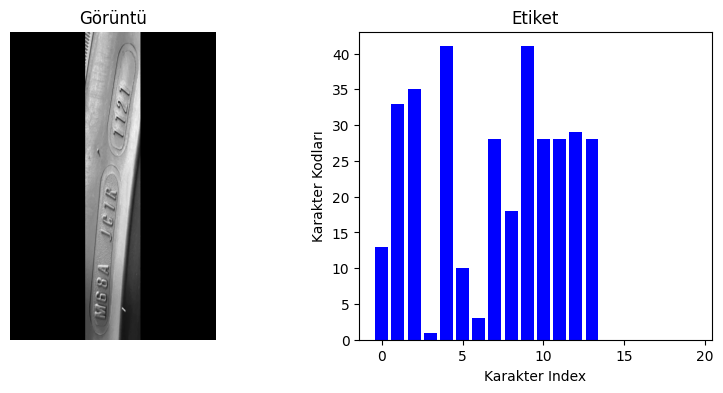

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[13 37 19 41 29 30 32 39 32 32 18 29 27 41 28 27 29 22  0  0]]


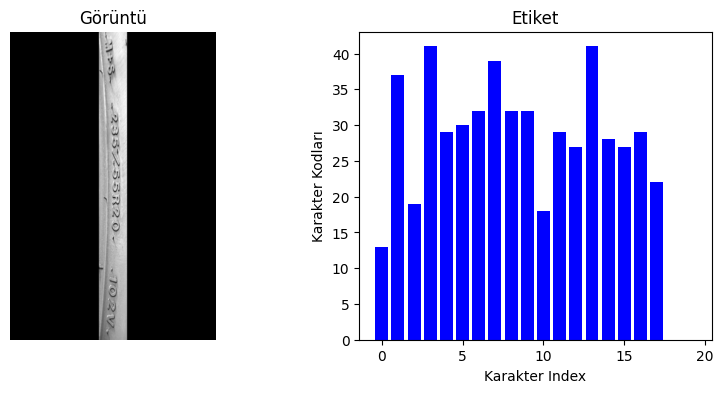

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[ 6  4  6 32 41 16  5 11 31 32 28 32  0  0  0  0  0  0  0  0]]


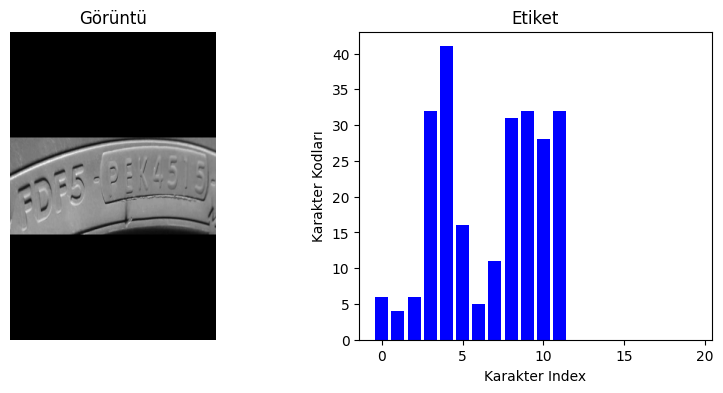

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[28 35 32 39 32 32 41 18 41 28 32  0  0  0  0  0  0  0  0  0]]


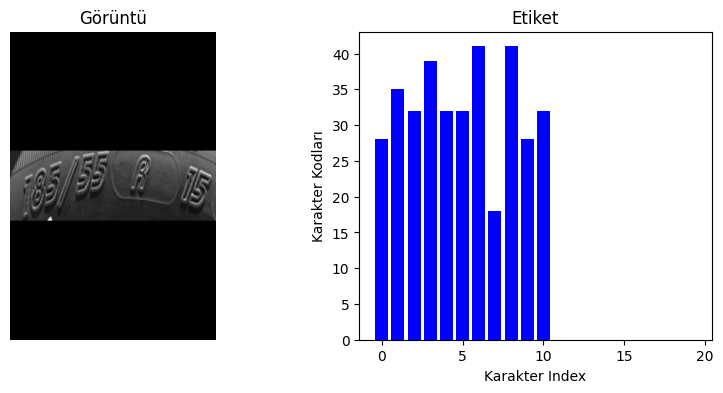

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[29 28 32 39 32 32 41 18 28 34  0  0  0  0  0  0  0  0  0  0]]


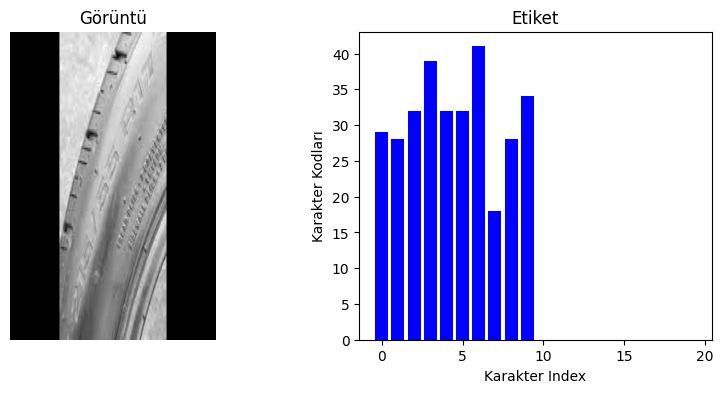

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[14 12 33 30 41 11 22 28 18 41 30 28 28 29  0  0  0  0  0  0]]


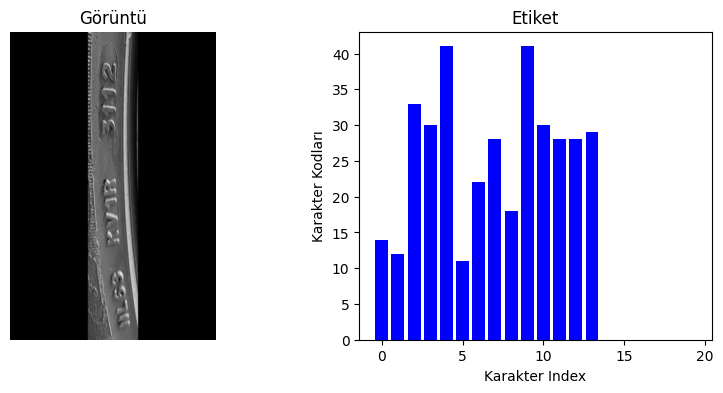

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[29 27 32 41 32 27 26 18 28 34 41 36 30 23  0  0  0  0  0  0]]


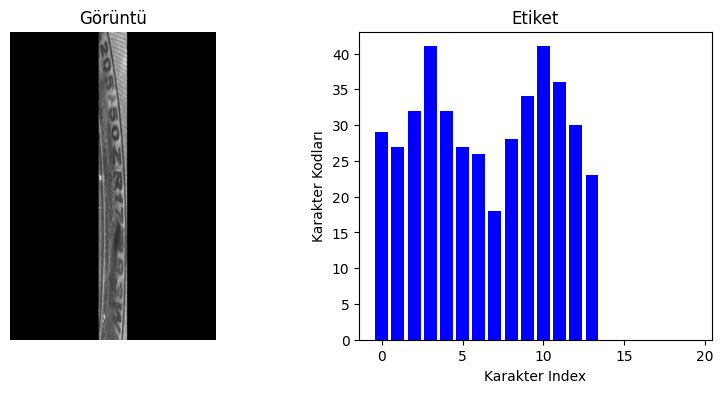

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[13 37 19 41 29 31 32 39 32 27 18 28 35 41 28 27 27 22  0  0]]


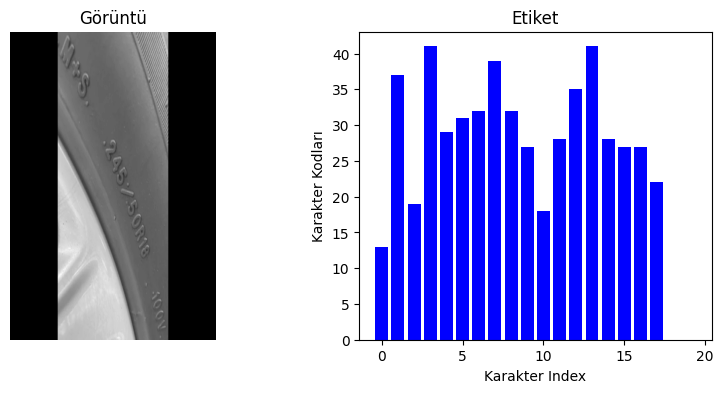

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[29 34 32 39 31 27 18 29 27  0  0  0  0  0  0  0  0  0  0  0]]


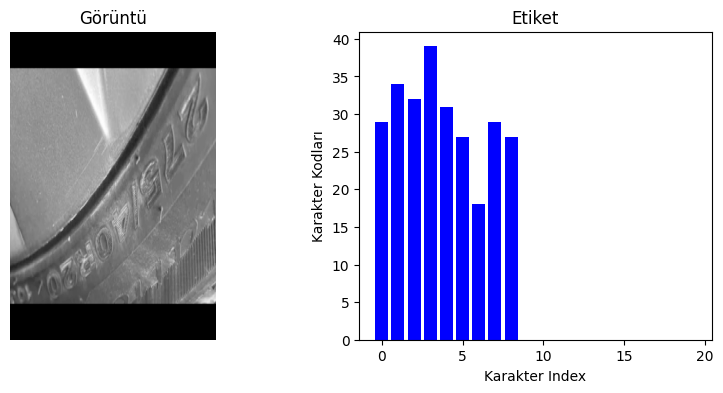

Doğrulama Verisi Örnekleri:
Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[29 31 32 39 31 32 26 18 29 27 41 28 27 30 23 41 24 12  0  0]]


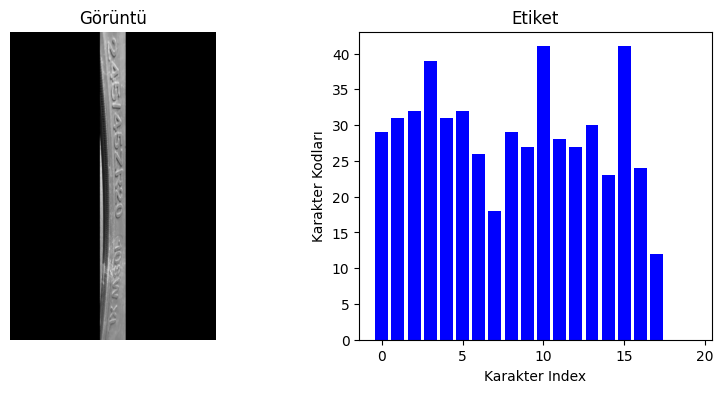

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[29 31 32 39 31 27 18 28 35 41 36 34 23  0  0  0  0  0  0  0]]


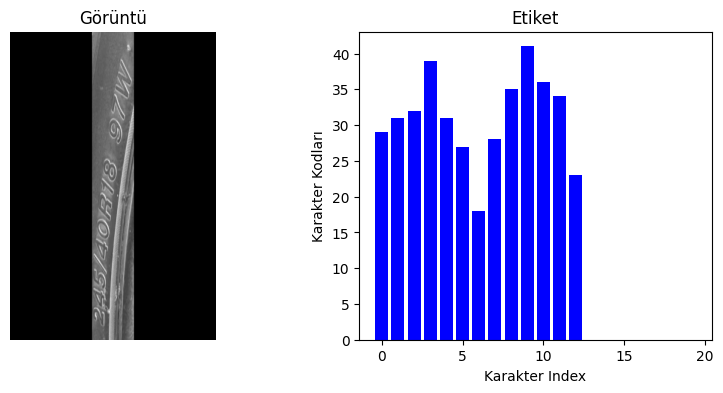

Test Verisi Örnekleri:
Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[ 4 15 20 41  8  3 14 31 41 27 28  6 24 41 28 31 28 34  0  0]]


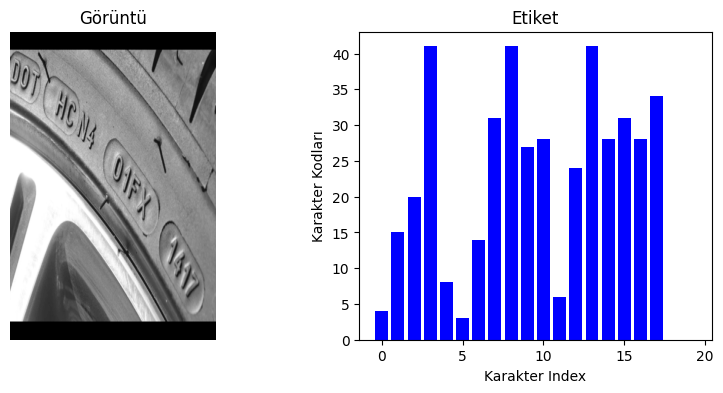

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[20 27 27  2 41 27 35 28 33  0  0  0  0  0  0  0  0  0  0  0]]


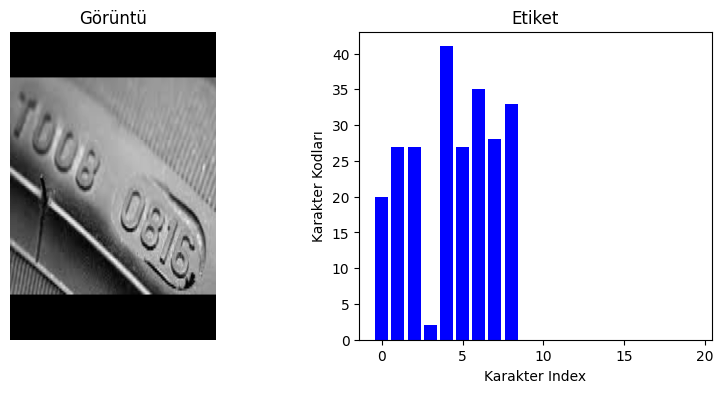

Orijinal Görüntü Şekli: (1, 600, 400, 1)
Yeniden Şekillendirilmiş Görüntü Şekli: (600, 400)
Etiket Şekli: (1, 20), Etiket İçeriği: [[29 28 32 39 32 32 18 28 34 41 36 31 22 41 13 37 19  0  0  0]]


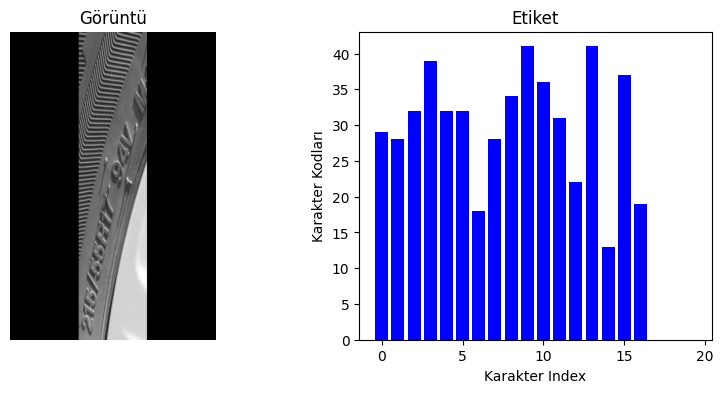

In [61]:
def display_sample(dataset, num_samples=10):
    for img, lbl in dataset.take(num_samples):
        print(f"Orijinal Görüntü Şekli: {img.shape}")
        img = img.numpy().reshape((img.shape[1], img.shape[2]))
        print(f"Yeniden Şekillendirilmiş Görüntü Şekli: {img.shape}")

        lbl = lbl.numpy()
        print(f"Etiket Şekli: {lbl.shape}, Etiket İçeriği: {lbl}")

        lbl = lbl.squeeze()
        if lbl.ndim > 1:
            lbl = lbl.flatten()


        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Görüntü')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.bar(range(len(lbl)), lbl, color='blue')
        plt.title('Etiket')
        plt.xlabel('Karakter Index')
        plt.ylabel('Karakter Kodları')

        plt.show()



print("Eğitim Verisi Örnekleri:")
display_sample(train_dataset)

print("Doğrulama Verisi Örnekleri:")
display_sample(val_dataset)

print("Test Verisi Örnekleri:")
display_sample(test_dataset)

In [16]:
from tensorflow.keras import layers, models

def build_model_crnn(input_shape, num_class):
  model = models.Sequential()

  #input layer
  model.add(layers.Input(shape=input_shape))

  #cnn
  model.add(layers.Conv2D(32,(3,3), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  """
  model.add(layers.Conv2D(64,(3,3), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))

  model.add(layers.Conv2D(128,(3,3), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  """
  #flatten layer
  model.add(layers.Flatten())

  #rnn
  model.add(layers.Reshape((-1, model.output_shape[-1])))
  model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))

  #output
  model.add(layers.TimeDistributed(layers.Dense(num_class, activation='softmax')))

  return model

In [17]:
def ctc_loss_function(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]
    input_length = tf.fill([batch_size], tf.shape(y_pred)[1])
    input_length = tf.cast(input_length, tf.int32)
    label_length = tf.fill([batch_size], tf.shape(y_true)[1])
    label_length = tf.cast(label_length, tf.int32)
    y_true = tf.cast(y_true, tf.int32)

    loss = tf.nn.ctc_loss(
        labels=y_true,
        logits=y_pred,
        label_length=label_length,
        logit_length=input_length,
        logits_time_major=False,
        blank_index=num_class -1
    )

    return tf.reduce_mean(loss)

In [18]:
input_shape = (600, 400, 1)
num_class = len(vocab) + 1

model = build_model_crnn(input_shape, num_class)
model.compile(optimizer=Adam(), loss = ctc_loss_function, metrics=['accuracy'])
model.summary()

sample_output = model.predict(np.random.rand(1, 600, 400, 1))
print("Model Output Shape:", sample_output.shape)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 600, 400, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 600, 400, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 600, 400, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 300, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1920000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1920000)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 64)               │     491,528,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 42)               │           2,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 491,556,458 (1.83 GB)

 Trainable params: 491,556,394 (1.83 GB)

 Non-trainable params: 64 (256.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model Output Shape: (1, 1, 42)


In [19]:
import psutil
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [20]:
class RAMUsageLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        process = psutil.Process()
        ram_usage = process.memory_info().rss / (1024 * 1024)  # RAM kullanımı MB cinsinden
        print(f"Epoch {epoch + 1} sonu RAM Kullanımı: {ram_usage:.2f} MB")

**MODELİ EĞİTME**

In [ ]:
epochs = 10
batch = 1
patience = 2

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
ram_logger = RAMUsageLogger()

history = model.fit(train_dataset, validation_data = val_dataset, epochs=epochs, callbacks=[early_stopping, ram_logger], verbose=2)

Epoch 1/10
Epoch 1 sonu RAM Kullanımı: 8519.59 MB
8/8 - 104s - 13s/step - accuracy: 0.0750 - loss: 709.9324 - val_accuracy: 0.0500 - val_loss: 709.9265
Epoch 2/10


In [1]:
!free

               total        used        free      shared  buff/cache   available
Mem:        13290460     1081508    11301372        1724      907580    11920788
Swap:              0           0           0


**KAYIP GRAFİĞİ**

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.Legend()
plt.show()

**DOĞRULUK GRAFİĞİ**

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.Legend()
plt.show()

**MODELİ DEĞERLENDİRME**

In [ ]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

**MODELİ KULLANMA**

In [ ]:
def decode_prediction(pred):
  return ''.join([int_to_char[i] for i in pred])

In [ ]:
def predict_image(image_path, bounding_box):
  img = preprocess_img(image_path, bounding_box)
  img = np.expand_dims(img, axis=0)
  prediction = model.predict(img)
  predicted_label = np.argmax(prediction, axis=2)[0]  # Predict for sequence
  return decode_prediction(predicted_label)

In [ ]:
sample_img = test_images[0]
sample_bb = test_bounding_boxes[0]
predicted_label = predict_image(sample_img, sample_bb)
print(f'Predicted label: {predicted_label}')